Codes from : https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-3e2c1f52-6c12-4904-f7d9-d676daf5056b)


In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv


--2022-11-03 22:42:35--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.008s  

2022-11-03 22:42:35 (20.3 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [3]:
import pandas as pd
df=pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
               parse_dates=["Date"],
               index_col=["Date"])
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [5]:
len(df)

2787

In [6]:
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


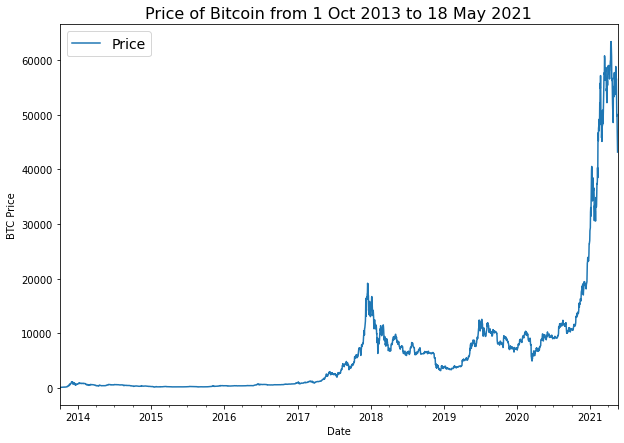

In [7]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

In [8]:
import csv
from datetime import datetime

timesteps=[]
btc_price=[]
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader=csv.reader(f, delimiter=",")
  next(csv_reader)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))
    btc_price.append(float(line[2]))

timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

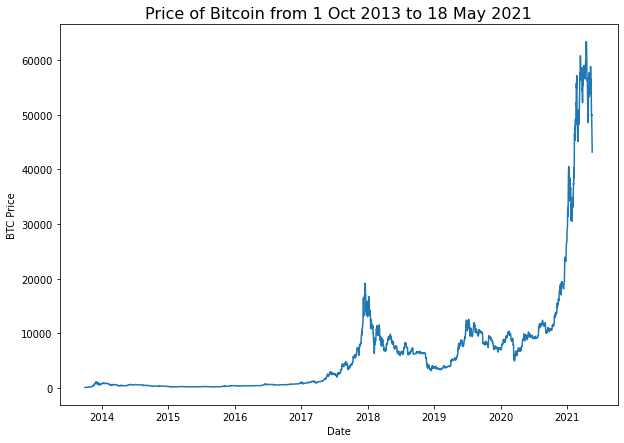

In [9]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize = 16)
plt.xlabel("Date")
plt.ylabel("BTC Price");

In [10]:
timesteps=bitcoin_prices.index.to_numpy()
prices=bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(timesteps,
                                                  prices,
                                                  test_size=0.2,
                                                  random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

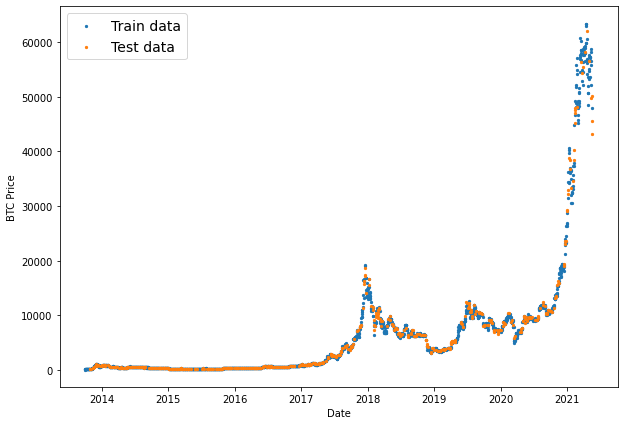

In [12]:
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

In [13]:
split_size= int(0.8* len(prices))

X_train, y_train=timesteps[:split_size], prices[:split_size]

X_test, y_test=timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

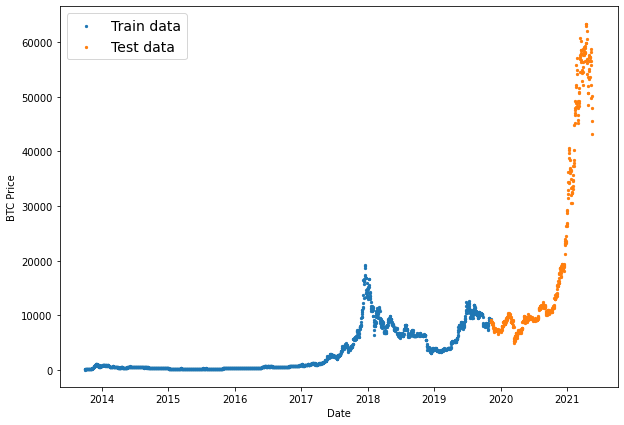

In [14]:
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

In [15]:
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

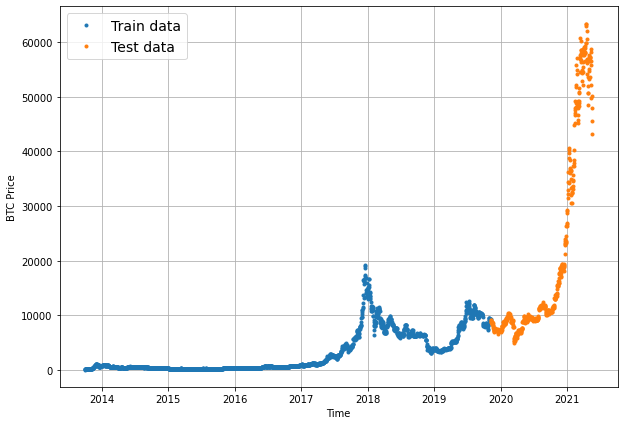

In [16]:
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

Model 0 : Naive Forecast

In [17]:
naive_forecast=y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

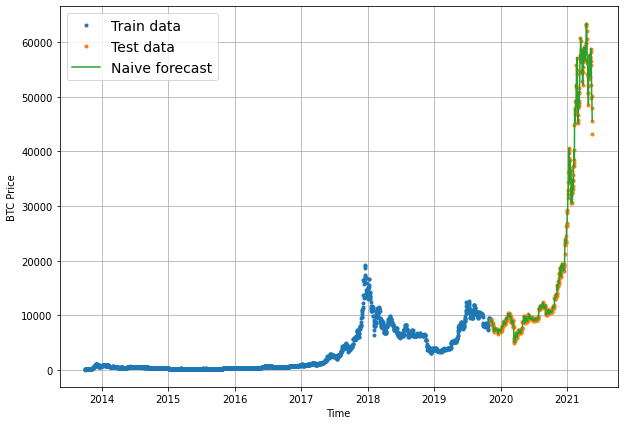

In [18]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

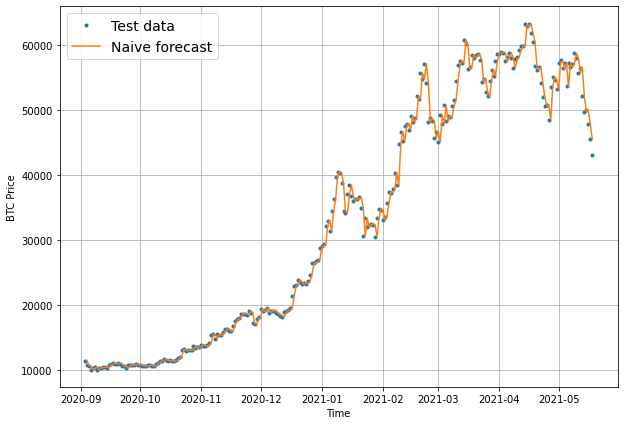

In [19]:
plt.figure(figsize=(10,7))
offset=300
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

Scaled errors

In [20]:
import tensorflow as tf

In [21]:
def mean_absolute_scaled_error(y_true, y_pred):
  mae=tf.reduce_mean(tf.abs(y_true-y_pred))
  mae_naive_no_season=tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))
  return mae / mae_naive_no_season

In [22]:
def evaluate_preds(y_true, y_pred):
  y_true=tf.cast(y_true, dtype=tf.float32)
  y_pred=tf.cast(y_pred, dtype=tf.float32)

  mae=tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse=tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse=tf.sqrt(mse)
  mape=tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase=mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [23]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [24]:
tf.reduce_mean(y_test).numpy()

20056.632963737222

Other kinds of time series forecasting models which can be used for baselines and actual forecasts

In [25]:
HORIZON=1
WINDOW_SIZE=7

In [26]:
def get_labelled_windows(x, horizon=1):
  return x[:, :-horizon], x[:, -horizon:]

In [27]:
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [28]:
def make_windows(x, window_size=7, horizon=1):
  window_step=np.expand_dims(np.arange(window_size+horizon), axis=0)
  window_indexes=window_step+np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  windowed_array=x[window_indexes]
  windows, labels=get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

In [29]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [30]:
for i in range(3):
  print(f"Window:{full_windows[i]} -> {full_labels[i]}")

Window:[123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> [123.033]
Window:[125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> [124.049]
Window:[108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> [125.96116]


In [31]:
for i in range(3):
  print(f"Window:{full_windows[i]} -> Label:{full_labels[i]}")

Window:[123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label:[123.033]
Window:[125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label:[124.049]
Window:[108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label:[125.96116]


In [32]:
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


Turning windows into training and test sets

In [33]:
def make_train_test_splits(windows, labels, test_split=0.2):
  split_size=int(len(windows)*(1-test_split))
  train_windows=windows[:split_size]
  train_labels=labels[:split_size]
  test_windows=windows[split_size:]
  test_labels=labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [34]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [35]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [36]:
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

Make a modelling checkpoint

In [37]:
import os
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

Model 1 Dense model

In [38]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

model_1=tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_1_dense")

model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
18/18 [==============================] - 3s 39ms/step - loss: 780.3455 - mae: 780.3455 - val_loss: 2279.6528 - val_mae: 2279.6528
Epoch 2/100
18/18 [==============================] - 1s 34ms/step - loss: 247.6756 - mae: 247.6756 - val_loss: 1005.9993 - val_mae: 1005.9993
Epoch 3/100
18/18 [==============================] - 0s 27ms/step - loss: 188.4116 - mae: 188.4116 - val_loss: 923.2862 - val_mae: 923.2861
Epoch 4/100
18/18 [==============================] - 0s 26ms/step - loss: 169.4340 - mae: 169.4340 - val_loss: 900.5872 - val_mae: 900.5872
Epoch 5/100
18/18 [==============================] - 0s 26ms/step - loss: 165.0894 - mae: 165.0894 - val_loss: 895.2237 - val_mae: 895.2237
Epoch 6/100
18/18 [==============================] - 0s 27ms/step - loss: 158.5210 - mae: 158.5210 - val_loss: 855.1984 - val_mae: 855.1984
Epoch 7/100
18/18 [==============================] - 0s 26ms/step - loss: 151.3566 - mae: 151.3566 - val_loss: 840.9166 - val_mae: 840.9166
Epoch 8/100
18/1

In [39]:
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 585.9758 - mae: 585.9758


[585.9757690429688, 585.9757690429688]

In [40]:
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 568.9510 - mae: 568.9510


[568.9510498046875, 568.9510498046875]

Making forecast with a model

In [41]:
def make_preds(model, input_data):
  forecast= model.predict(input_data)
  return tf.squeeze(forecast)

In [42]:
model_1_preds=make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 2ms/step


(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8861.71 , 8769.887, 9015.711, 8795.519, 8723.811, 8730.111,
        8691.952, 8502.054, 8460.961, 8516.548], dtype=float32)>)

In [43]:
model_1_results=evaluate_preds(y_true=tf.squeeze(test_labels),
                               y_pred=model_1_preds)
model_1_results

{'mae': 568.9511,
 'mse': 1171743.8,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 0.99948955}

In [44]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

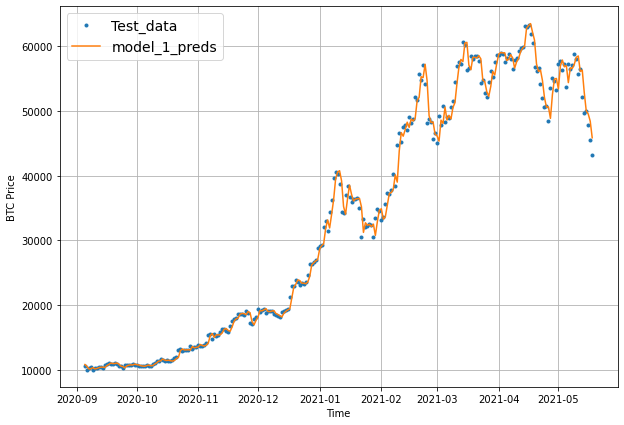

In [45]:
offset=300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:,0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

Model 2: Dense

In [46]:
HORIZON=1
WINDOW_SIZE=30

In [47]:
full_windows, full_labels=make_windows(prices, window_size=WINDOW_SIZE, horizon = HORIZON )
len(full_windows), len(full_labels)

(2757, 2757)

In [48]:
train_windows, test_windows, train_labels, test_labels=make_train_test_splits(windows=full_windows, labels= full_labels)
len(train_labels), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [49]:
tf.random.set_seed(42)
model_2=tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [50]:
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 659.3332


659.3331909179688

In [51]:
model_2=tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 605.8741


605.8740844726562

In [52]:
model_2_preds=make_preds(model_2,
                         input_data=test_windows)

18/18 [==============================] - 0s 1ms/step


In [53]:
model_2_results=evaluate_preds(y_true=tf.squeeze(test_labels),
                               y_pred=model_2_preds)
model_2_results

{'mae': 605.8741,
 'mse': 1273360.8,
 'rmse': 1128.4329,
 'mape': 2.726445,
 'mase': 1.0590738}

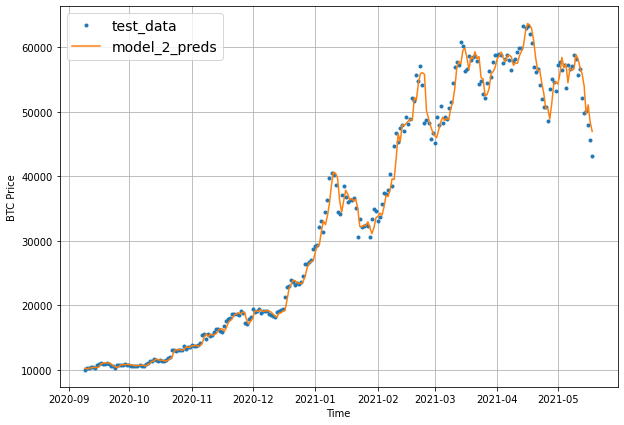

In [54]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

Model 3

In [55]:
HORIZON=7
WINDOW_SIZE=30

full_windows, full_labels=make_windows(prices, window_size = WINDOW_SIZE, horizon= HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [56]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [57]:
tf.random.set_seed(42)
model_3=tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name= "model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [58]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1300.1525


1300.1524658203125

In [59]:
model_3=tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1237.5065


1237.5064697265625

In [60]:
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9004.694 , 9048.1   , 9425.09  , 9258.256 , 9495.797 , 9558.453 ,
        9357.3545],
       [8735.506 , 8840.303 , 9247.793 , 8885.601 , 9097.186 , 9174.327 ,
        9156.818 ],
       [8672.508 , 8782.387 , 9123.857 , 8770.371 , 9007.13  , 9003.869 ,
        9042.725 ],
       [8874.399 , 8784.74  , 9043.902 , 8943.052 , 9033.477 , 9176.489 ,
        9039.677 ],
       [8825.891 , 8777.44  , 8926.78  , 8870.179 , 9213.232 , 9268.156 ,
        8942.487 ]], dtype=float32)>

In [61]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([ 513.6056  ,  355.08328 ,  327.17075 ,  358.5106  ,  420.53305 ,
         537.854   ,  545.66156 ,  485.9228  ,  584.49713 ,  687.3824  ,
         836.2264  ,  755.1577  ,  731.4958  ,  775.3399  ,  567.95544 ,
         266.80865 ,  188.80225 ,  188.10799 ,  253.095   ,  301.43256 ,
         151.10721 ,  196.81473 ,  191.46178 ,  231.65031 ,  143.61125 ,
         122.59089 ,  132.78879 ,  190.8118  ,  179.15994 ,  228.26018 ,
         314.44022 ,  379.09244 ,  278.32526 ,  295.3471  ,  299.3852  ,
         248.64983 ,  299.75662 ,  259.69434 ,  180.30531 ,  206.72922 ,
         374.62863 ,  144.85086 ,  142.33635 ,  131.11613 ,   93.941124,
          54.825542,   73.79541 ,  103.60128 ,  121.333916,  168.67278 ,
         183.90945 ,  152.25307 ,  186.57191 ,  146.91267 ,  240.42912 ,
         351.00662 ,  540.952   ,  549.1573  ,  521.2411  ,  526.8554  ,
         453.36237 ,  257.98117 ,  277.29486 ,  301.8247  ,  455.718   ,
         458.96017 ,  503.4438  ,  522.3119 

Make our evaluation function work for larger horizons

In [62]:
def evaluate_preds(y_true, y_pred):
  y_true=tf.cast(y_true, dtype=tf.float32)
  y_pred=tf.cast(y_pred, dtype=tf.float32)

  mae=tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse=tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse=tf.sqrt(mse)
  mape=tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase=mean_absolute_scaled_error(y_true, y_pred)

  if mae.ndim > 0 :
    mae=tf.reduce_mean(mae)
    mse=tf.reduce_mean(mse)
    rmse=tf.reduce_mean(rmse)
    mape=tf.reduce_mean(mape)
    mase=tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [63]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)

model_3_results

{'mae': 1237.5065,
 'mse': 5405199.0,
 'rmse': 1425.7478,
 'mape': 5.558879,
 'mase': 2.2020733}

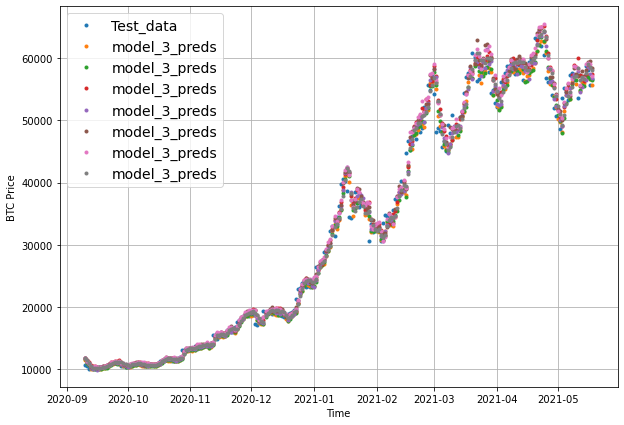

In [64]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

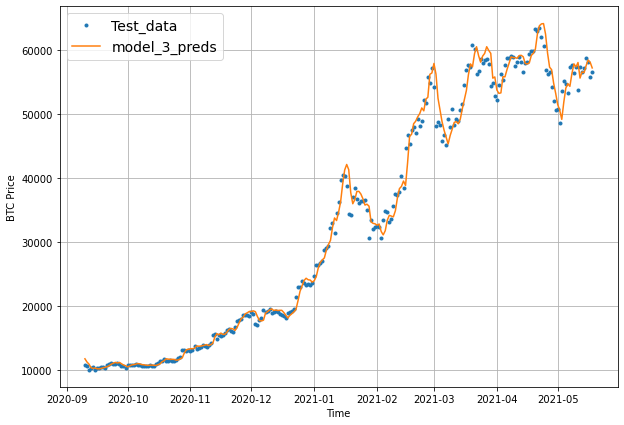

In [65]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1), 
                 format="-",
                 start=offset, 
                 label="model_3_preds")

Which of our models is performing best so far?

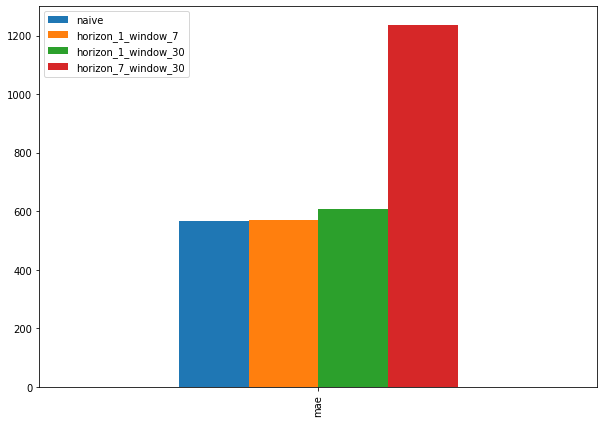

In [66]:
pd.DataFrame({"naive": naive_results["mae"], 
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_1_window_30": model_2_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

Model 4 Conv1D

In [67]:
HORIZON=1
WINDOW_SIZE=7

In [68]:
full_windows, full_labels=make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)          

(2780, 2780)

In [69]:
train_windows, test_windows, train_labels, test_labels=make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [70]:
train_windows[0].shape

(7,)

In [71]:
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) 
print(f"Original shape: {x.shape}") 
print(f"Expanded shape: {expand_dims_layer(x).shape}") 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [72]:
tf.random.set_seed(42)

# Create
model_4 = tf.keras.Sequential([
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_4.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [73]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [74]:
model_4=tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 570.8284


570.828369140625

In [75]:
#Making predictions
model_4_preds=make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8851.464, 8754.47 , 8983.927, 8759.671, 8703.627, 8708.294,
       8661.667, 8494.839, 8435.316, 8492.114], dtype=float32)>

In [76]:
#Evaluate predictions
model_4_results=evaluate_preds(y_true=tf.squeeze(test_labels),
                               y_pred=model_4_preds)
model_4_results

{'mae': 570.82837,
 'mse': 1176671.2,
 'rmse': 1084.7448,
 'mape': 2.5593357,
 'mase': 1.0027874}

Model 5 : RNN (LSTM)

In [77]:
tf.random.set_seed(42)

inputs=layers.Input(shape=(WINDOW_SIZE))
x=layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)

x=layers.LSTM(128, activation = "relu")(x)

output=layers.Dense(HORIZON)(x)
model_5=tf.keras.Model(inputs=inputs, outputs=output,name="model_5_lstm")

model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [78]:
model_5= tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 594.6030


594.6029663085938

In [79]:
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8978.46 , 8810.951, 8997.779, 8836.308, 8731.047, 8776.852,
       8733.2  , 8541.157, 8503.402, 8531.719], dtype=float32)>

In [80]:
model_5_results=evaluate_preds(y_true=tf.squeeze(test_labels),
                               y_pred=model_5_preds)
model_5_results

{'mae': 594.60297,
 'mse': 1267231.9,
 'rmse': 1125.7139,
 'mape': 2.6717565,
 'mase': 1.0445527}

Make a multivariate time series

In [81]:
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [82]:
block_reward_1=50
block_reward_2=25
block_reward_3=12.5
block_reward_4=6.25

block_reward_2_datetime=np.datetime64("2012-11-28")
block_reward_3_datetime=np.datetime64("2016-07-09")
block_reward_4_datetime=np.datetime64("2020-05-11")

In [83]:
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [84]:
bitcoin_prices_block=bitcoin_prices.copy()
bitcoin_prices_block["block_reward"]=None

bitcoin_prices_block.iloc[:block_reward_2_days, -1]= block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


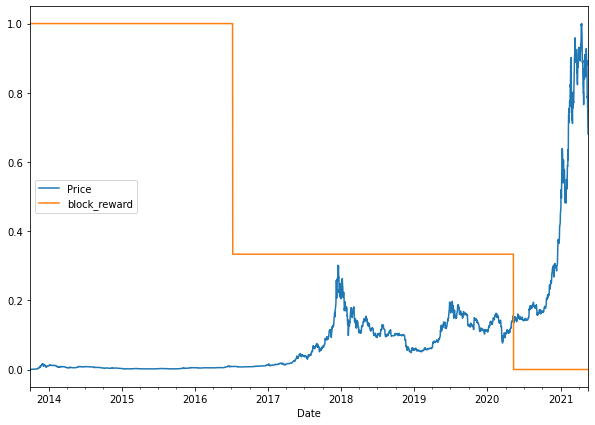

In [85]:
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

Making a windowed dataset with pandas

In [86]:
HORIZON=1
WINDOW_SIZE=7

In [87]:
bitcoin_prices_windowed=bitcoin_prices_block.copy()

for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)

bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [88]:
X= bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32) 
y=bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [89]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [90]:
split_size=int(len(X)*0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

Model 6: Dense (multivariate time series)

In [91]:
tf.random.set_seed(42)

model_6=tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

#Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

#Fit 
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

In [92]:
model_6=tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 567.8910


567.8909912109375

In [93]:
model_6_preds=tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8844.684, 8769.905, 9045.17 , 8747.686, 8728.429, 8772.757,
       8667.292, 8503.437, 8470.313, 8527.244], dtype=float32)>

In [94]:
#Evaluate
model_6_results=evaluate_preds(y_true=y_test,
                               y_pred=model_6_preds)
model_6_results

{'mae': 567.8909,
 'mse': 1164817.6,
 'rmse': 1079.2671,
 'mape': 2.5460868,
 'mase': 0.9976271}

In [95]:
model_6_results

{'mae': 567.8909,
 'mse': 1164817.6,
 'rmse': 1079.2671,
 'mape': 2.5460868,
 'mase': 0.9976271}

Model 7: N-BEATS algorithm

In [96]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): 
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):  
    x = inputs 
    for layer in self.hidden: 
      x = layer(x)
    theta = self.theta_layer(x) 
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [97]:
dummy_nbeats_block_layer=NBeatsBlock(input_size=WINDOW_SIZE,
                                     theta_size=WINDOW_SIZE+HORIZON,
                                     horizon=HORIZON,
                                     n_neurons=128,
                                     n_layers=4)

In [98]:
dummy_inputs=tf.expand_dims(tf.range(WINDOW_SIZE)+1, axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [99]:
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)

print(f"Backcast:{tf.squeeze(backcast.numpy())}")
print(f"Forecast:{tf.squeeze(forecast.numpy())}")

Backcast:[ 0.19014993  0.83798355 -0.3287001   0.2515993  -0.47540283 -0.7783665
 -0.5299447 ]
Forecast:-0.7554212808609009


Preparing data for the N-BEATS algorithm using tf.data

In [100]:
HORIZON=1
WINDOW_SIZE=7

In [101]:
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [102]:
bitcoin_prices_nbeats=bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"]=bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [103]:
X=bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y=bitcoin_prices_nbeats.dropna()["Price"]

split_size=int(len(X) *0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [104]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset=tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset=tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset=tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset=tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

#3.Batch & prefetch for optimal performance
BATCH_SIZE=1024
train_dataset=train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

Setting up hyperparameters for N-BEATS algorithm

In [105]:
N_EPOCHS=5000
N_NEURONS=512
N_LAYERS=4
N_STACKS=30

INPUT_SIZE=WINDOW_SIZE * HORIZON 
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

Getting ready for residual connections

In [106]:
#Making tensors
tensor_1=tf.range(10)+10
tensor_2=tf.range(10)

#Substarct
subtracted=layers.subtract([tensor_1, tensor_2])

#ADD
added=layers.add([tensor_1, tensor_2])

print(f"Input tensors : {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added:{added.numpy()}")

Input tensors : [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added:[10 12 14 16 18 20 22 24 26 28]


Building, compiling and fitting the N-BEATS algorithm

In [107]:
%%time

tf.random.set_seed(42)

#Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# Create initial backcast and forecast input 
backcast, forecast = nbeats_block_layer(stack_input)

#Residual 
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): 

  # Use the NBeatsBlock to calculate
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) 

  #Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_7_N-BEATS")

# Compile with MAE loss & Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# Fit the model with EarlyStopping & ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, 
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 288: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 388: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 1min 8s, sys: 1.69 s, total: 1min 10s
Wall time: 1min 14s


In [108]:
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 19ms/step - loss: 592.7946 - mae: 592.7946 - mse: 1195560.0000


[592.7945556640625, 592.7945556640625, 1195560.0]

In [109]:
model_7_preds=make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8931.413, 8835.744, 8975.574, 8820.268, 8809.215, 8739.651,
       8643.528, 8577.408, 8473.625, 8496.373], dtype=float32)>

In [110]:
model_7_results=evaluate_preds(y_true=y_test,
                               y_pred=model_7_preds)
model_7_results

{'mae': 592.79456,
 'mse': 1195560.0,
 'rmse': 1093.4166,
 'mape': 2.7454169,
 'mase': 1.0413759}

Plotting the N-BEATS architecture we've created

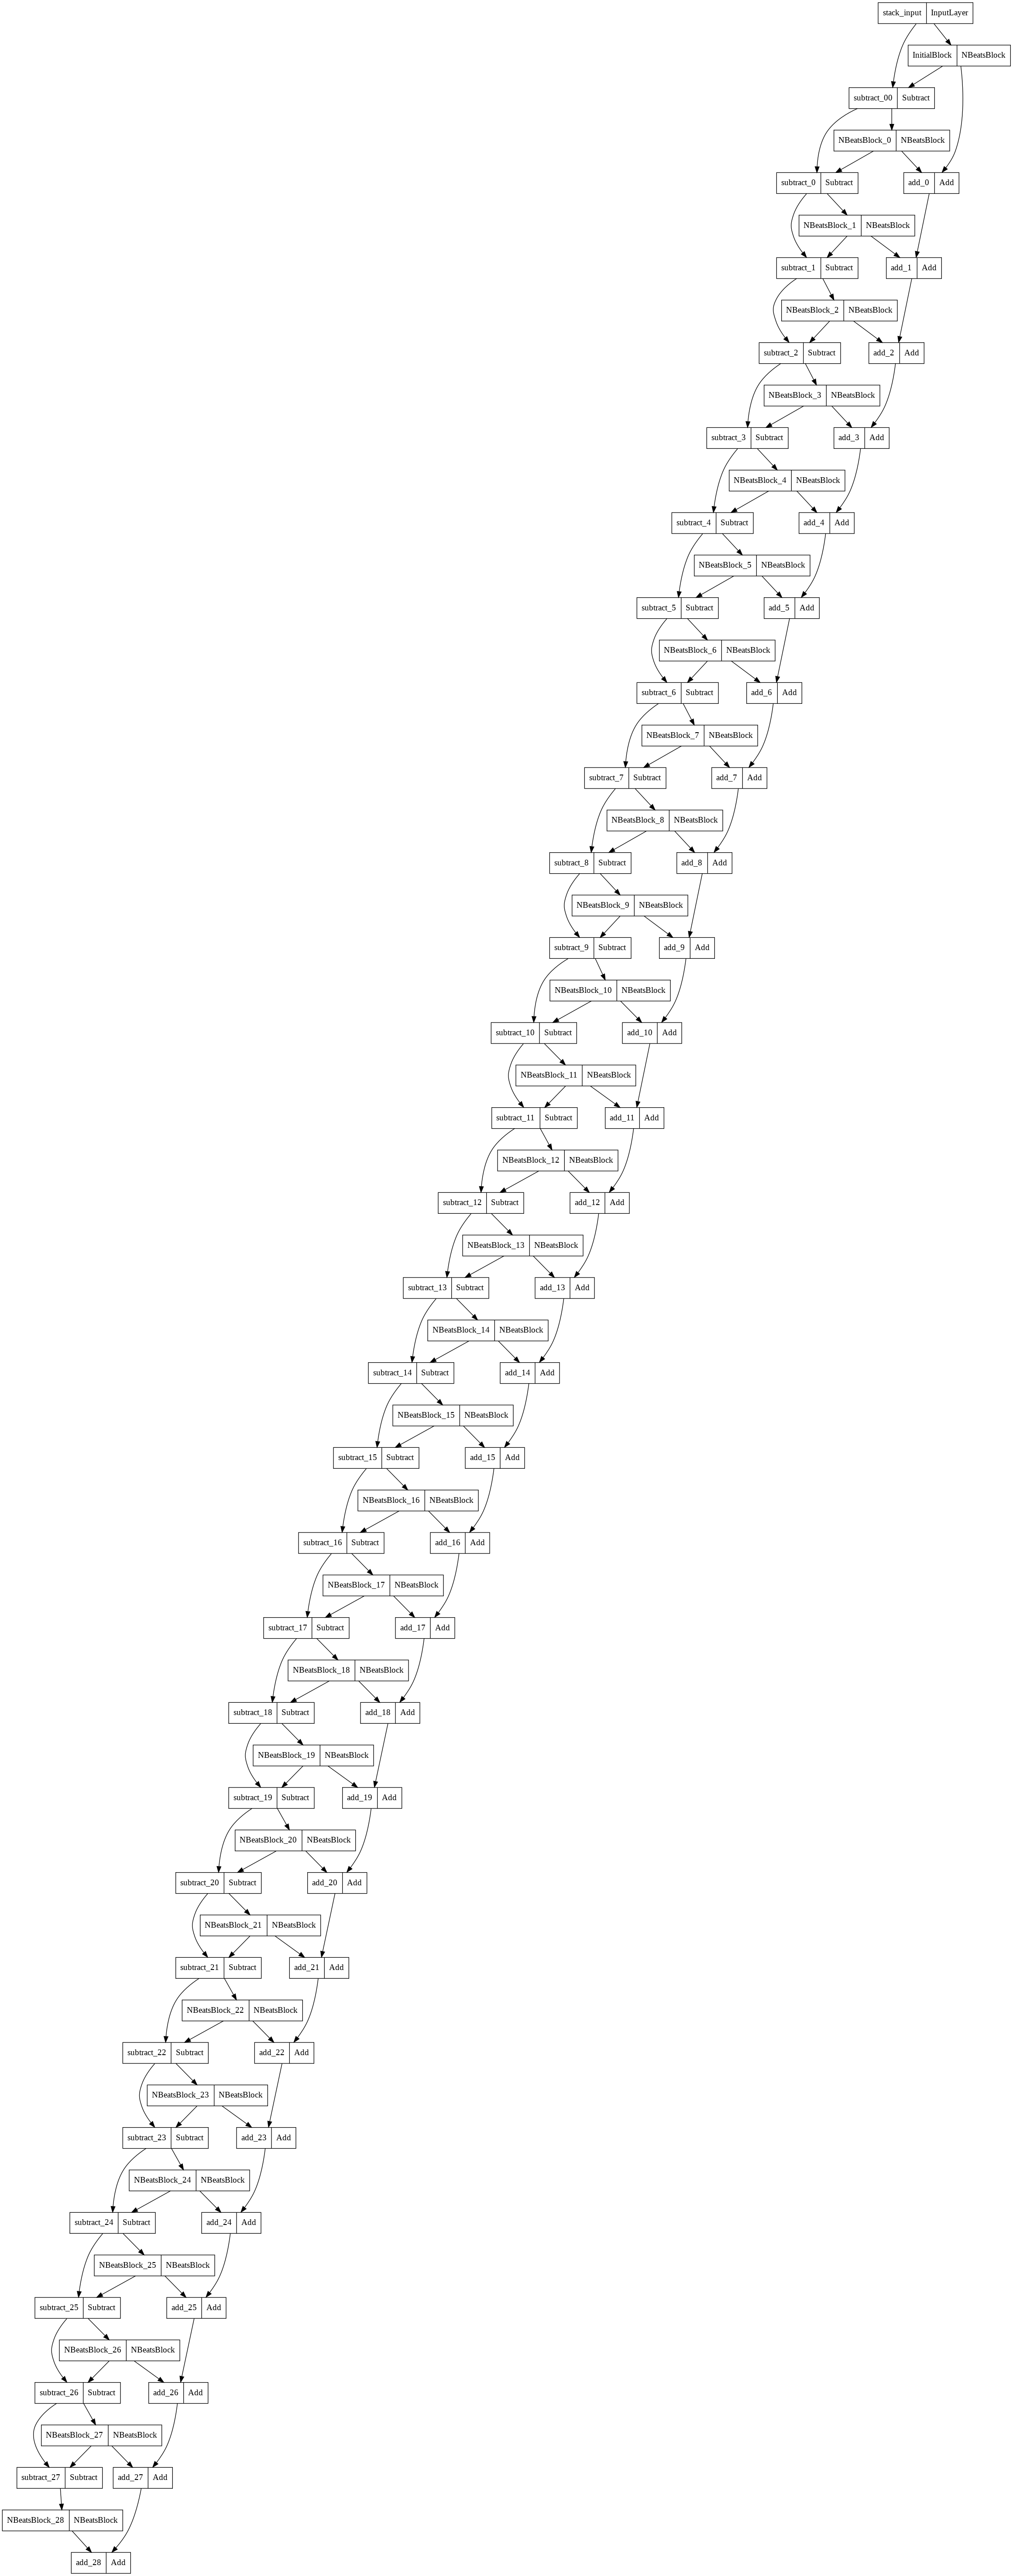

In [111]:
from tensorflow.keras.utils import plot_model
plot_model(model_7)

In [112]:
model_7.save(model_7.name)

Model 8: Creating an ensemble (stacking different models together)

Constructing and fitting an ensemble of models (using different loss functions)

In [113]:
def get_ensemble_models(horizon=HORIZON, 
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10, 
                        num_epochs=100, 
                        loss_fns=["mae", "mse", "mape"]):
  
  ensemble_models = []


  for i in range(num_iter):
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      model = tf.keras.Sequential([
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"), 
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)                                 
      ])

      # Compile
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      ensemble_models.append(model)

  return ensemble_models 

In [114]:
%%time
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 585: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 700: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 800: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 168: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 268: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 887: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 409: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 509: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by redu

Making predictions with an ensemble model

In [115]:
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) 
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [116]:
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 31ms/step


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8788.912 ,  8794.214 ,  9073.959 , ..., 50563.6   , 49910.707 ,
        46646.312 ],
       [ 8762.739 ,  8738.393 ,  9050.093 , ..., 49312.01  , 48529.29  ,
        45321.684 ],
       [ 8745.424 ,  8733.034 ,  9101.386 , ..., 49267.164 , 47660.426 ,
        45370.047 ],
       ...,
       [ 8957.877 ,  8794.538 ,  9064.803 , ..., 49622.043 , 49881.957 ,
        46676.203 ],
       [ 8727.596 ,  8803.125 ,  9102.268 , ..., 49582.12  , 48529.406 ,
        45036.574 ],
       [ 8815.599 ,  8759.639 ,  9039.1045, ..., 49722.434 , 48066.15  ,
        45827.87  ]], dtype=float32)>

In [117]:
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) 
ensemble_results

{'mae': 566.83246,
 'mse': 1143088.5,
 'rmse': 1069.1532,
 'mape': 2.5823085,
 'mase': 0.99576765}

Plotting the prediction intervals (uncertainty estimates) of our ensemble

In [118]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): 
  
  std = tf.math.reduce_std(preds, axis=0)
  
  #Multiply standard deviation by 1.96
  interval = 1.96 * std 

  #Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

lower, upper = get_upper_lower(preds=ensemble_preds)

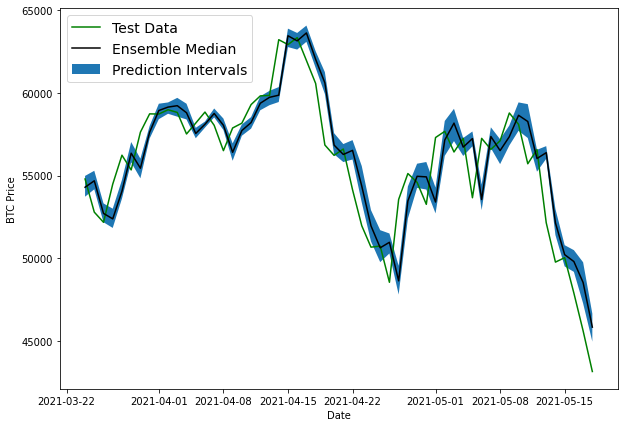

In [119]:
# Median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:], 
                 (lower)[offset:], 
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

Model 9: Train a model on the full historical data to make predictions into future

In [120]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [121]:
X_all=bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy()
y_all=bitcoin_prices_windowed.dropna()["Price"].to_numpy()

In [122]:
#Turn X & y into tensor Datasets
features_dataset_all=tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all=tf.data.Dataset.from_tensor_slices(y_all)

#Combine
dataset_all=tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

#Batch & prefetch 
BATCH_SIZE = 1024
dataset_all=dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [123]:
tf.random.set_seed(42)
model_9=tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
])
#Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())
#Fit
model_9.fit(dataset_all,
            epochs=100,
            verbose=0)

Make predictions on the future

In [124]:
INTO_FUTURE=14

In [125]:
# Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:

  # Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] 

  # Make INTO_FUTURE number of predictions
  for _ in range(into_future):
    
    # Predict
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    
    # Append
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [126]:
future_forecast=make_future_forecast(values=y_all,
                                     model=model_9,
                                     into_future=INTO_FUTURE,
                                     window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 43ms/step
Predicting on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55764.47265625

1/1 [==============================] - 0s 13ms/step
Predicting on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55764.47265625] -> Prediction: 50985.9296875

1/1 [==============================] - 0s 14ms/step
Predicting on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55764.47265625 50985.9296875 ] -> Prediction: 48522.9609375

1/1 [==============================] - 0s 14ms/step
Predicting on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55764.47265625 50985.9296875  48522.9609375 ] -> Prediction: 48137.19921875

1/1 [==============================] - 0s 17ms/step
Predicting on: 
 [47885.62525472 45604.61575361 43144.47129086 55764.47265625
 50985.9296875  48522.9609375  48137.199

In [127]:
future_forecast[:10]

[55764.473,
 50985.93,
 48522.96,
 48137.2,
 47880.633,
 46879.715,
 48227.594,
 53963.684,
 49685.543,
 47596.176]

Plot future forecasts

In [128]:
def get_future_dates(start_date, into_future, offset=1):
  satrt_date=start_date+np.timedelta64(offset, "D")
  end_date=start_date+np.timedelta64(into_future, "D")
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [129]:
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [130]:
next_time_steps = get_future_dates(start_date=last_timestep, 
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
       '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
       '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
       '2021-05-30', '2021-05-31'], dtype='datetime64[D]')

In [131]:
next_time_steps=np.insert(next_time_steps, 0, last_timestep)
future_forecast=np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-18', '2021-05-19', '2021-05-20',
        '2021-05-21', '2021-05-22', '2021-05-23', '2021-05-24',
        '2021-05-25', '2021-05-26', '2021-05-27', '2021-05-28',
        '2021-05-29', '2021-05-30', '2021-05-31'], dtype='datetime64[D]'),
 array([43144.473, 55764.473, 50985.93 , 48522.96 , 48137.2  , 47880.633,
        46879.715, 48227.594, 53963.684, 49685.543, 47596.176, 48114.418,
        48807.996, 48623.85 , 50178.715], dtype=float32))

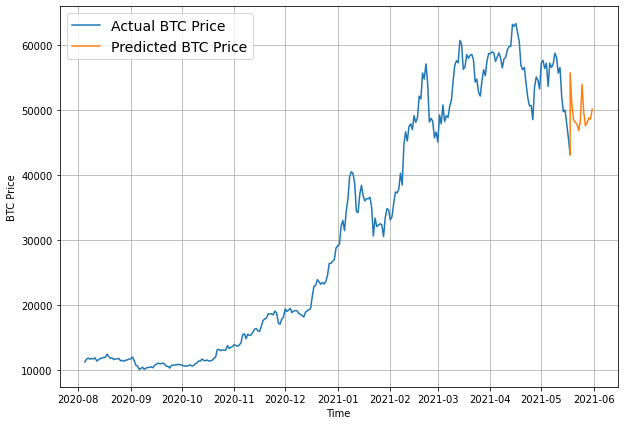

In [132]:
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

Model 10: Why forecasting is BS (the turkey problem)

In [133]:
btc_price_turkey=btc_price.copy()
btc_price_turkey[-1]=btc_price_turkey[-1]/100

In [134]:
btc_price_turkey[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 431.44471290860304]

In [135]:
btc_timesteps_turkey=np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

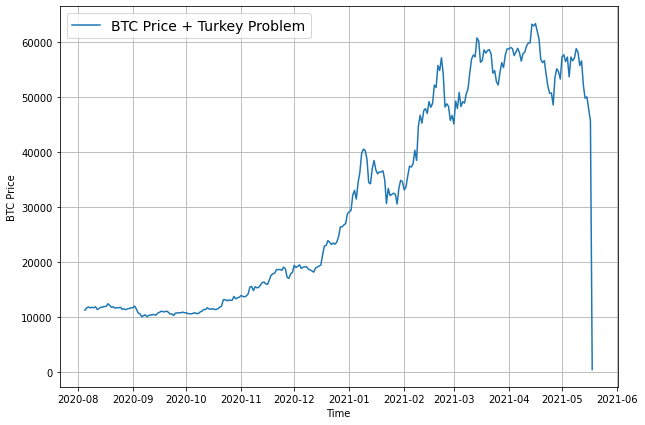

In [136]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey, 
                 values=btc_price_turkey, 
                 format="-", 
                 label="BTC Price + Turkey Problem", 
                 start=2500)

In [137]:
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

Building a turkey model (model to predict on turkey data)

In [138]:
turkey_model=tf.keras.models.clone_model(model_1)
turkey_model._name="Turkey_Model"
turkey_model.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam())
turkey_model.fit(X_train, y_train,
                 epochs=100,
                 verbose=0,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])

In [139]:
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 786.2139


786.2139282226562

In [140]:
turkey_model = tf.keras.models.load_model("model_experiments/Turkey_Model/")
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 638.3048


638.3048095703125

In [143]:
#Prediction
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

18/18 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8858.391, 8803.98 , 9039.576, 8785.936, 8778.044, 8735.638,
       8684.117, 8558.66 , 8461.372, 8542.205], dtype=float32)>

In [144]:
#Evaluate
turkey_results=evaluate_preds(y_true=y_test,
                              y_pred=turkey_preds)
turkey_results

{'mae': 17144.766,
 'mse': 615487740.0,
 'rmse': 23743.303,
 'mape': 121.58286,
 'mase': 26.53158}

In [145]:
model_1_results

{'mae': 568.9511,
 'mse': 1171743.8,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 0.99948955}

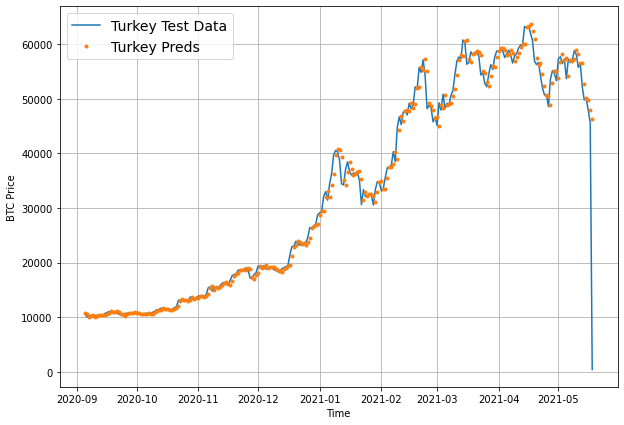

In [146]:
plt.figure(figsize=(10, 7))
offset=300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):], 
                 values=btc_price_turkey[-len(y_test):], 
                 format="-", 
                 label="Turkey Test Data", start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds, 
                 label="Turkey Preds", 
                 start=offset);

Final Part : Compare Models

In [147]:
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_8_NBEATs": model_7_results,
                              "model_9_ensemble": ensemble_results,
                              "model_10_turkey": turkey_results}).T
model_results.head(10)

,mae,mse,rmse,mape,mase
naive_model,567.980225,1.147547e+06,1071.236206,2.516525,0.999570
model_1_dense_w7_h1,568.951111,1.171744e+06,1082.471069,2.544898,0.999490
model_2_dense_w30_h1,605.874084,1.273361e+06,1128.432861,2.726445,1.059074
model_3_dense_w30_h7,1237.506470,5.405199e+06,1425.747803,5.558879,2.202073
model_4_CONV1D,570.828369,1.176671e+06,1084.744751,2.559336,1.002787
model_5_LSTM,594.602966,1.267232e+06,1125.713867,2.671757,1.044553
model_6_multivariate,567.890930,1.164818e+06,1079.267090,2.546087,0.997627
model_8_NBEATs,592.794556,1.195560e+06,1093.416626,2.745417,1.041376
model_9_ensemble,566.832458,1.143088e+06,1069.153198,2.582309,0.995768
model_10_turkey,17144.765625,6.154877e+08,23743.302734,121.582863,26.531580


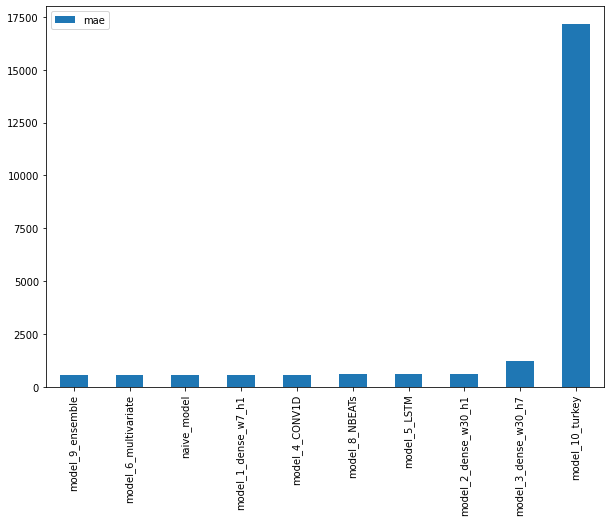

In [148]:
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10,7), kind="bar");

And FINISH